In [1]:
# pip install yellowbrick
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.width', 500)
#adjusting the display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_ = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")
df = df_.copy()

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.select_dtypes(include=[np.number]).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

In [4]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [5]:
df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [6]:
analysis_date = df['last_order_date'].max() + dt.timedelta(days=2)
df["recency"] = (analysis_date - df["last_order_date"]).dt.days
df["tenure"] = (analysis_date - df["first_order_date"]).dt.days

In [7]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],5.000,939.370,95,214
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.000,2013.550,105,1574
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",5.000,585.320,186,552
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",2.000,121.970,135,146
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],2.000,209.980,86,668


In [8]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #date cols
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'datetime64[ns]']


    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat and col not in date_cols]


    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'date_cols: {len(date_cols)}')

    return cat_cols, num_cols, cat_but_car, date_cols

cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)

Observations: 19945
Variables: 16
cat_cols: 2
num_cols: 8
cat_but_car: 2
num_but_cat: 0
date_cols: 4


In [9]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online',
 'order_num_total',
 'customer_value_total',
 'recency',
 'tenure']

In [10]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))


order_num_total_ever_online True
order_num_total_ever_offline True
customer_value_total_ever_offline True
customer_value_total_ever_online True
order_num_total True
customer_value_total True
recency False
tenure False


In [11]:
for col in num_cols:
    print(col, check_outlier(df, col))  
    if check_outlier(df, col):  # Check for outliers in the column
        replace_with_thresholds(df, col)  # Replace outliers in `df` directly

order_num_total_ever_online True
order_num_total_ever_offline True
customer_value_total_ever_offline True
customer_value_total_ever_online True
order_num_total True
customer_value_total True
recency False
tenure False


In [12]:
for col in num_cols:
    print(col, check_outlier(df, col))

order_num_total_ever_online False
order_num_total_ever_offline False
customer_value_total_ever_offline False
customer_value_total_ever_online False
order_num_total False
customer_value_total False
recency False
tenure False


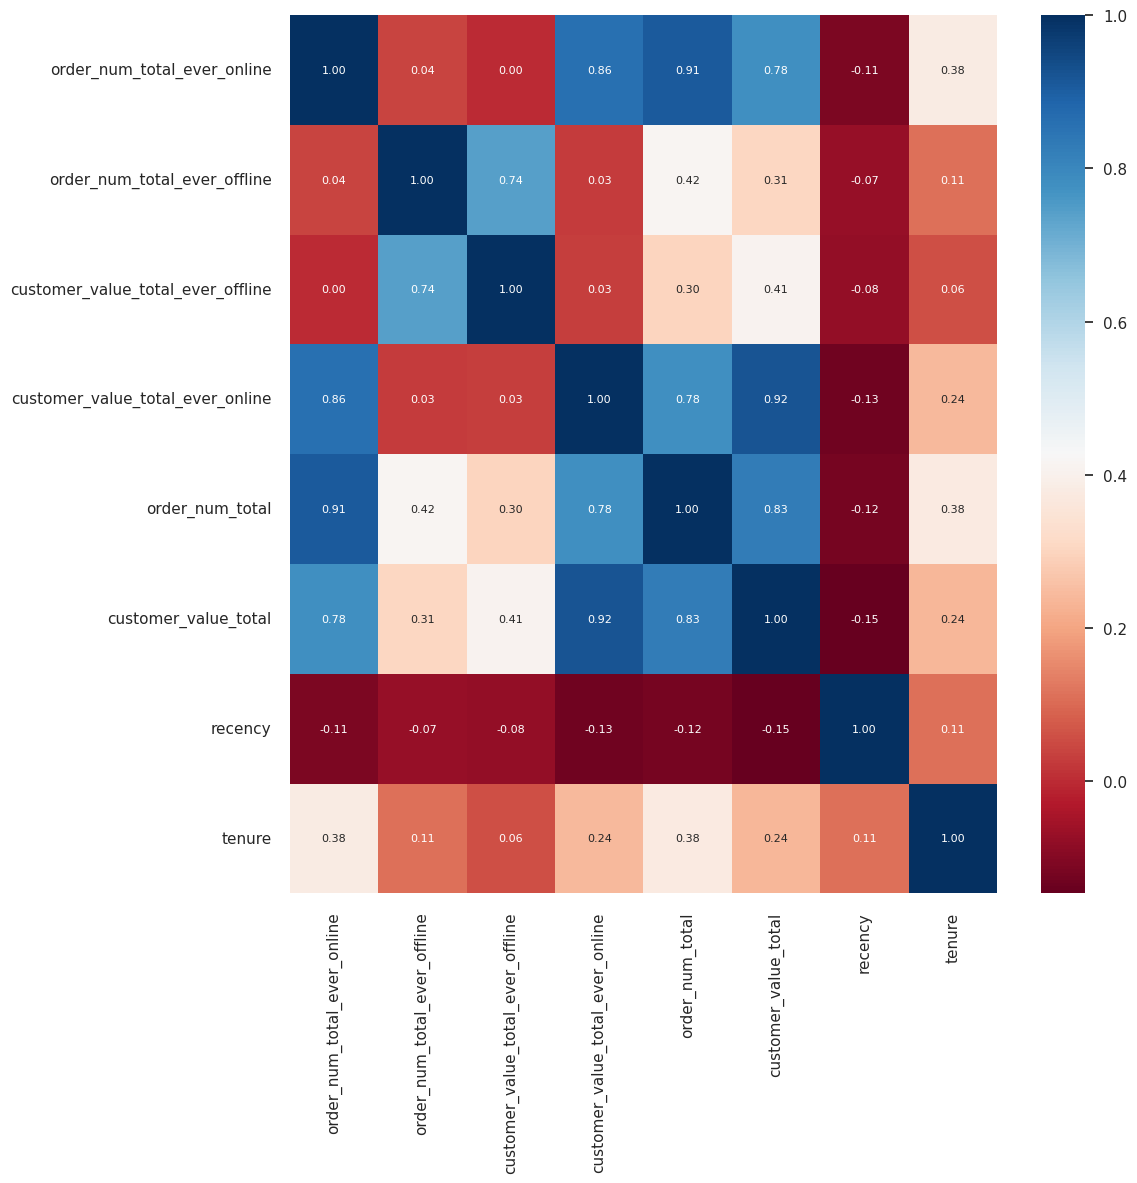

In [13]:
# Sayısal sütunlarla veri çerçevesini filtreleyin
df_numeric = df[num_cols]
# Korelasyon Analizi (Analysis of Correlation)
corr = df_numeric.corr()
# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f", annot_kws={"size": 8})
plt.tight_layout()
plt.show()

In [14]:
cat_cols, num_cols, cat_but_car, date_cols = grab_col_names(df)
df_new = df[num_cols]
df_new.head()

Observations: 19945
Variables: 16
cat_cols: 2
num_cols: 8
cat_but_car: 2
num_but_cat: 0
date_cols: 4


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,order_num_total,customer_value_total,recency,tenure
0,4.000,1.000,139.990,799.380,5.000,939.370,95,214
1,19.000,2.000,159.970,1853.580,21.000,2013.550,105,1574
2,3.000,2.000,189.970,395.350,5.000,585.320,186,552
3,1.000,1.000,39.990,81.980,2.000,121.970,135,146
4,1.000,1.000,49.990,159.990,2.000,209.980,86,668


In [15]:
sc = MinMaxScaler((0, 1))
df_new = sc.fit_transform(df_new)
df_new[0:5]

array([[0.06315789, 0.        , 0.04318774, 0.10099337, 0.06      ,
        0.10163593, 0.25479452, 0.06841244],
       [0.37894737, 0.06666667, 0.04982587, 0.23638065, 0.38      ,
        0.22370269, 0.28219178, 0.51358429],
       [0.04210526, 0.06666667, 0.05979304, 0.04910518, 0.06      ,
        0.0614027 , 0.50410959, 0.17905074],
       [0.        , 0.        , 0.00996385, 0.00886015, 0.        ,
        0.00874892, 0.36438356, 0.04615385],
       [0.        , 0.        , 0.01328624, 0.01887871, 0.        ,
        0.01875013, 0.23013699, 0.21702128]])

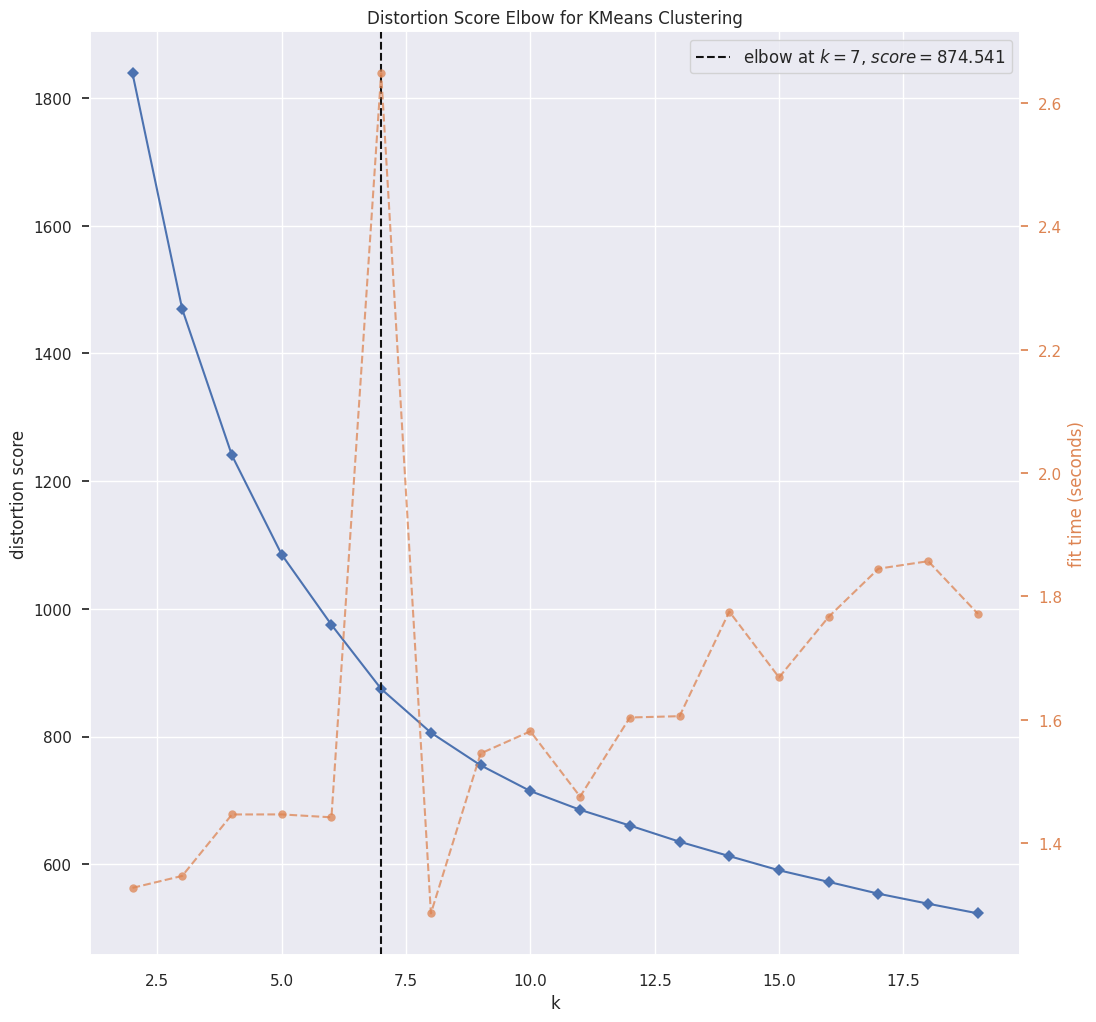

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_new)
elbow.show()

In [17]:
elbow.elbow_value_

7

In [18]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_new)

In [19]:
kmeans.n_clusters

7

In [20]:
kmeans.cluster_centers_

array([[0.03241088, 0.0397599 , 0.06635419, 0.05358333, 0.04271831,
        0.06760929, 0.11144581, 0.18334152],
       [0.02151595, 0.04401568, 0.06563133, 0.04004746, 0.03364486,
        0.05538495, 0.81874775, 0.22281201],
       [0.07273664, 0.05968689, 0.07983527, 0.06862145, 0.08700587,
        0.08552664, 0.71837118, 0.63245714],
       [0.38083974, 0.07815231, 0.08826669, 0.39905826, 0.38632959,
        0.38276389, 0.21721307, 0.46875939],
       [0.02399145, 0.04099589, 0.06586808, 0.04367334, 0.03509065,
        0.05867425, 0.43236264, 0.20377275],
       [0.04465652, 0.30514662, 0.28296082, 0.06628139, 0.14066427,
        0.15557887, 0.19826123, 0.25176051],
       [0.08346749, 0.05905421, 0.07878213, 0.07983619, 0.09701038,
        0.09508969, 0.19828222, 0.60602586]])

In [21]:
kmeans.labels_

array([0, 3, 4, ..., 0, 5, 1], dtype=int32)

In [22]:
clusters_kmeans = kmeans.labels_

In [23]:
df_new = pd.DataFrame(df_new, columns=num_cols)

In [24]:
df_new["cluster"] = clusters_kmeans

In [25]:
df_new["cluster"] = df_new["cluster"] + 1

In [26]:
df_new.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,order_num_total,customer_value_total,recency,tenure,cluster
0,0.063,0.000,0.043,0.101,0.060,0.102,0.255,0.068,1
1,0.379,0.067,0.050,0.236,0.380,0.224,0.282,0.514,4
2,0.042,0.067,0.060,0.049,0.060,0.061,0.504,0.179,5
3,0.000,0.000,0.010,0.009,0.000,0.009,0.364,0.046,5
4,0.000,0.000,0.013,0.019,0.000,0.019,0.230,0.217,1


In [27]:
df_new.groupby("cluster").agg({"mean","median", "min", "max","count"})

order_num_total_ever_online                          order_num_total_ever_offline                          customer_value_total_ever_offline                          customer_value_total_ever_online                          order_num_total                          customer_value_total                          recency                          tenure                         
                                min   max  mean median count                          min   max  mean median count                               min   max  mean median count                              min   max  mean median count             min   max  mean median count                  min   max  mean median count     min   max  mean median count    min   max  mean median count
cluster                                                                                                                                                                                                                                                                                                                                                                                        
1                             0.000 0.358 0.032  0.021  6998                        0.000 0.267 0.040  0.000  6998                             0.001 0.464 0.066  0.053  6998                            0.000 0.457 0.054  0.036  6998           0.000 0.340 0.043  0.040  6998                0.001 0.436 0.068  0.055  6998   0.000 0.282 0.111  0.093  6998  0.000 0.441 0.183  0.189  6998
2                             0.000 0.358 0.022  0.000  3316                        0.000 0.733 0.044  0.000  3316                             0.000 0.568 0.066  0.047  3316                            0.000 0.452 0.040  0.027  3316           0.000 0.340 0.034  0.020  3316                0.000 0.406 0.055  0.045  3316   0.622 1.000 0.819  0.841  3316  0.077 0.490 0.223  0.209  3316
3                             0.000 0.505 0.073  0.042  1023                        0.000 0.667 0.060  0.000  1023                             0.001 0.613 0.080  0.056  1023                            0.000 0.430 0.069  0.046  1023           0.000 0.500 0.087  0.060  1023                0.005 0.403 0.086  0.069  1023   0.447 1.000 0.719  0.704  1023  0.355 0.996 0.632  0.613  1023
4                             0.042 1.000 0.381  0.337   534                        0.000 1.000 0.078  0.067   534                             0.001 1.000 0.088  0.060   534                            0.115 1.000 0.399  0.349   534           0.040 1.000 0.386  0.340   534                0.141 1.000 0.383  0.334   534   0.000 0.940 0.217  0.153   534  0.028 1.000 0.469  0.453   534
5                             0.000 0.358 0.024  0.000  5516                        0.000 0.333 0.041  0.000  5516                             0.000 0.442 0.066  0.050  5516                            0.001 0.383 0.044  0.029  5516           0.000 0.340 0.035  0.020  5516                0.001 0.363 0.059  0.048  5516   0.263 0.630 0.432  0.433  5516  0.033 0.502 0.204  0.201  5516
6                             0.000 0.337 0.045  0.021  1115                        0.000 1.000 0.305  0.267  1115                             0.027 1.000 0.283  0.240  1115                            0.000 0.445 0.066  0.045  1115           0.020 1.000 0.141  0.120  1115                0.033 1.000 0.156  0.134  1115   0.000 0.915 0.198  0.178  1115  0.016 0.909 0.252  0.249  1115
7                             0.000 0.316 0.083  0.063  1443                        0.000 0.533 0.059  0.067  1443                             0.001 0.468 0.079  0.063  1443                            0.001 0.364 0.080  0.063  1443           0.000 0.320 0.097  0.080  1443                0.000 0.384 0.095  0.084  1443   0.000 0.463 0.199  0.200  1443  0.344 0.998 0.606  0.584  1443

*** Cluster 7 has highest max/mean values for 'customer_value_total',  relatively recent engagement 'recency' and 'highest order_num_total'. Cluster 7 fits the definition of Champions better than other clusters.**

*** Cluster 4 and 5 could represent Loyal Customers / Potential Loyalists due to its high tenure but not the most recent engagement.**

*** Cluster 6 could represent "About to Sleep" or "Hibernating" as they have  low customer_value_total mean and max, low order_num_total.**

*** Cluster 1 could represent 'Promising' as they have moderate values in customer_value_total and order_num_total with decent recency.**

*** Cluster 2 and 3 could represent 'At-Risk Customers'. These customers may have made significant purchases in the past but haven’t engaged recently. They could be a focus for win-back campaigns to prevent churn.**


**Targeted Strategies:**
**High-Value Clusters: Consider retention strategies, loyalty programs, or exclusive offers.**

**Frequent Buyers: Clusters where order_num_total strongly correlates with customer_value_total might respond well to volume-based discounts or subscription models.**

**New or Low Tenure Customers: For clusters with low tenure but high potential (e.g., Cluster 6), we should consider engagement strategies to increase their customer lifetime value.**


In [28]:
#Hypothesis
# H0; normality is met
# H1: normality isn't met

from scipy.stats import shapiro

# Specify the numeric columns to be analyzed
numeric_columns = df_new.drop(["cluster"], axis=1)

# Test for normality for each cluster and each numeric column
for label in df_new["cluster"].unique():
    print(f"Normality tests for Cluster {label}:")
    cluster_data = df_new[df_new["cluster"] == label]
    
    for column in numeric_columns:
        stat, p = shapiro(cluster_data[column])
        print(f"{column} - Shapiro-Wilk p-value: {p}")
        # If p < 0.05, the normality assumption is not met.
    print("\n")  # Adds spaces to separate each cluster

Normality tests for Cluster 1:
order_num_total_ever_online - Shapiro-Wilk p-value: 1.4082417160375743e-73
order_num_total_ever_offline - Shapiro-Wilk p-value: 2.5013600347090256e-75
customer_value_total_ever_offline - Shapiro-Wilk p-value: 1.1430259551300964e-58
customer_value_total_ever_online - Shapiro-Wilk p-value: 2.0492769621192576e-69
order_num_total - Shapiro-Wilk p-value: 5.827698785593597e-65
customer_value_total - Shapiro-Wilk p-value: 8.550137189871038e-62
recency - Shapiro-Wilk p-value: 1.7997527337000267e-47
tenure - Shapiro-Wilk p-value: 1.4461754830699596e-28


Normality tests for Cluster 4:
order_num_total_ever_online - Shapiro-Wilk p-value: 4.792803653964101e-22
order_num_total_ever_offline - Shapiro-Wilk p-value: 1.12333048698512e-30
customer_value_total_ever_offline - Shapiro-Wilk p-value: 1.2196838766142699e-29
customer_value_total_ever_online - Shapiro-Wilk p-value: 9.09588448824861e-22
order_num_total - Shapiro-Wilk p-value: 5.113723918836894e-22
customer_value_to

/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6998.
  res = hypotest_fun_out(*samples, **kwds)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5516.
  res = hypotest_fun_out(*samples, **kwds)


**The results are written with a negative power of 10, so these values are actually very close to zero, well below 0.05
1.1171185237531973e-58 means 1.1171185237531973 x 10^(-58), which is very close to zero 
This refers to a value that is almost zero (too many zeros), such as 0.000...001117**

**Since I got this warning "UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6998." when conducting Shapiro test, I will go ahead and try Kolmogorov-Smirnov normality test to make sure nothing goes unnoticed.**

In [29]:
#Hypothesis
# H0; normality is met
# H1: normality isn't met

from scipy.stats import kstest

# Loop through each cluster and each numeric column
for label in df_new["cluster"].unique():
    print(f"Kolmogorov-Smirnov normality test for Cluster {label}:")
    cluster_data = df_new[df_new["cluster"] == label]

    for column in numeric_columns:
        # Perform K-S test against a normal distribution
        stat, p = kstest(cluster_data[column], 'norm', args=(cluster_data[column].mean(), cluster_data[column].std()))
        print(f"{column} K-S test p-value: {p}")
        # p < 0.05 indicates non-normality
    print("\n")

Kolmogorov-Smirnov normality test for Cluster 1:
order_num_total_ever_online K-S test p-value: 0.0
order_num_total_ever_offline K-S test p-value: 0.0
customer_value_total_ever_offline K-S test p-value: 2.33772872726167e-80
customer_value_total_ever_online K-S test p-value: 4.8454928723471716e-163
order_num_total K-S test p-value: 2.8345825535589177e-242
customer_value_total K-S test p-value: 1.62131196561683e-91
recency K-S test p-value: 2.1377079739631682e-66
tenure K-S test p-value: 4.021019648115164e-24


Kolmogorov-Smirnov normality test for Cluster 4:
order_num_total_ever_online K-S test p-value: 6.840568607935771e-10
order_num_total_ever_offline K-S test p-value: 5.442999138565393e-29
customer_value_total_ever_offline K-S test p-value: 1.2658066984797715e-15
customer_value_total_ever_online K-S test p-value: 1.4870849623568274e-10
order_num_total K-S test p-value: 3.256984045316293e-11
customer_value_total K-S test p-value: 9.634264472058777e-10
recency K-S test p-value: 3.690397

**important;**
* The results are written with a negative power of 10, so these values are actually very close to zero, well below 0.05.

* 1.1171185237531973e-58 means 1.1171185237531973 x 10^(-58), which is very close to zero. 

* This refers to a value that is almost zero (too many zeros), such as 0.000...001117

* P-values < 0.5, therefore "H0; normality is met" is declined, in other words; normality isn't met.

* Since normality isn't met, moving forward with Kruskal non-parametric test

In [30]:
#Since normality isn't met, conducting Kruskal non-parametric test
from scipy.stats import kruskal

# Perform Kruskal-Wallis test for each numeric column
for column in numeric_columns:
    data_per_cluster = [df_new[df_new["cluster"] == label][column] for label in df_new["cluster"].unique()]
    stat, p = kruskal(*data_per_cluster)
    print(f"{column} Kruskal-Wallis p-value: {p}")
    # If p < 0.05, there is a significant difference between the clusters.

order_num_total_ever_online Kruskal-Wallis p-value: 0.0
order_num_total_ever_offline Kruskal-Wallis p-value: 0.0
customer_value_total_ever_offline Kruskal-Wallis p-value: 0.0
customer_value_total_ever_online Kruskal-Wallis p-value: 0.0
order_num_total Kruskal-Wallis p-value: 0.0
customer_value_total Kruskal-Wallis p-value: 0.0
recency Kruskal-Wallis p-value: 0.0
tenure Kruskal-Wallis p-value: 0.0


*** Based on the Kruskal-Wallis test results, the p-value for all variables was 0.0.**

*** Since p < 0.05, we can say that there are statistically significant differences between the clusters.**

*** In other words, at least one pair of clusters for each variable shows a significant difference in the distribution of this variable.**

*** These results reveal that there are differences in the distribution of all variables between the clusters.**

In [31]:
# Example Correlation Analysis within each cluster
for cluster in df_new['cluster'].unique():
    print(f"\nCorrelation Matrix for Cluster {cluster}:")
    print(df_new[df_new['cluster'] == cluster][['customer_value_total', 'order_num_total', 'recency', 'tenure']].corr())


Correlation Matrix for Cluster 1:
                      customer_value_total  order_num_total  recency  tenure
customer_value_total                 1.000            0.721   -0.103   0.120
order_num_total                      0.721            1.000   -0.077   0.262
recency                             -0.103           -0.077    1.000  -0.004
tenure                               0.120            0.262   -0.004   1.000

Correlation Matrix for Cluster 4:
                      customer_value_total  order_num_total  recency  tenure
customer_value_total                 1.000            0.522   -0.047  -0.046
order_num_total                      0.522            1.000    0.023   0.419
recency                             -0.047            0.023    1.000   0.142
tenure                              -0.046            0.419    0.142   1.000

Correlation Matrix for Cluster 5:
                      customer_value_total  order_num_total  recency  tenure
customer_value_total                 1.000      